# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.



Nishiura model: https://github.com/contactmodel/COVID19-Japan-Reff

Japan Data　　https://jag-japan.com/covid19map-readme/

In [1]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

#%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [2]:
#url = 'https://covidtracking.com/api/v1/states/daily.csv'
url = '/Users/---/japan.csv'
url = '/Users/---/COVID19_japan_data.csv'
data = pd.read_csv(url)

data = data.sort_values('STATE')#.dropna(how='any')#.set_index('STATE')

print('data\n',data)

state_list = data['STATE'].values.tolist()
all_name = sorted(list(set(state_list)))

#print(len(a))
#print(a)

dateidx = pd.date_range(start='2020-01-01',end='2020-05-28',freq='D')

d1 = datetime.strptime('2020-05-28', '%Y-%m-%d')
d0 = datetime.strptime('2020-02-01', '%Y-%m-%d')
window_size = (d1 - d0).days

#print(dateidx)

N0 = len(all_name)
N1 = dateidx.shape[0]

temp = pd.DataFrame(index=[0],columns=['STATE','DATE','POSITIVE','ONSET'])

for i in range(N0):
    for j in range(N1):

        temp.loc[i*N1+j] = [all_name[i],dateidx[j],0,0]
        
temp.DATE = pd.to_datetime(temp.DATE, format='%Y-%m-%d')
        
print('temp\n',temp)    


data
            STATE    POSITIVE       ONSET
4867       Aichi  2020-04-08  2020-03-31
3409       Aichi  2020-04-04  2020-03-27
3408       Aichi  2020-04-04  2020-04-02
3407       Aichi  2020-04-04  2020-03-31
3406       Aichi  2020-04-04  2020-04-01
...          ...         ...         ...
7577   Yamanashi  2020-04-13  2020-04-06
14390  Yamanashi  2020-05-01  2020-04-22
2390   Yamanashi  2020-04-01  2020-03-25
5332   Yamanashi  2020-04-09         NaN
1146   Yamanashi  2020-03-24  2020-03-24

[16355 rows x 3 columns]
temp
           STATE       DATE POSITIVE ONSET
0         Aichi 2020-01-01        0     0
1         Aichi 2020-01-02        0     0
2         Aichi 2020-01-03        0     0
3         Aichi 2020-01-04        0     0
4         Aichi 2020-01-05        0     0
...         ...        ...      ...   ...
6849  Yamanashi 2020-05-24        0     0
6850  Yamanashi 2020-05-25        0     0
6851  Yamanashi 2020-05-26        0     0
6852  Yamanashi 2020-05-27        0     0
6853  Ya

In [3]:
for i in range(data.shape[0]):
    
    indx_ = all_name.index(data.iat[i,0])
    
#positive
    if len(str(data.iat[i,1])) == 10:
        d1 = datetime.strptime(str(data.iat[i,1]), '%Y-%m-%d')
        d0 = datetime.strptime('2020-01-01', '%Y-%m-%d')
        indx_p = (d1 - d0).days

        temp.iloc[indx_*N1+indx_p,2] += 1

#onset
    if len(str(data.iat[i,2])) == 10:

        d1 = datetime.strptime(str(data.iat[i,2]), '%Y-%m-%d')
        d0 = datetime.strptime('2020-01-01', '%Y-%m-%d')
        indx_o = (d1 - d0).days
        
        temp.iloc[indx_*N1+indx_o,3] += 1


In [4]:
print(temp)


          STATE       DATE POSITIVE ONSET
0         Aichi 2020-01-01        0     0
1         Aichi 2020-01-02        0     0
2         Aichi 2020-01-03        0     0
3         Aichi 2020-01-04        0     0
4         Aichi 2020-01-05        0     0
...         ...        ...      ...   ...
6849  Yamanashi 2020-05-24        0     0
6850  Yamanashi 2020-05-25        0     0
6851  Yamanashi 2020-05-26        0     0
6852  Yamanashi 2020-05-27        0     0
6853  Yamanashi 2020-05-28        0     0

[6854 rows x 4 columns]


#### Clean data with known modifications

In [5]:
states000 = temp.set_index(['STATE','DATE'])
print(states000)

                     POSITIVE ONSET
STATE     DATE                     
Aichi     2020-01-01        0     0
          2020-01-02        0     0
          2020-01-03        0     0
          2020-01-04        0     0
          2020-01-05        0     0
...                       ...   ...
Yamanashi 2020-05-24        0     0
          2020-05-25        0     0
          2020-05-26        0     0
          2020-05-27        0     0
          2020-05-28        0     0

[6854 rows x 2 columns]


#### Integrity Check

In [6]:
def PREPARE():
    states = states000['POSITIVE']
    states = pd.DataFrame(states)
    states.columns=['POSITIVE']
#pd.set_option('display.max_rows', 7000)

    for state in all_name:
        
        temp2 = states.loc[pd.IndexSlice[state,:],:].cumsum()
        temp2 = temp2.sum(level='DATE')
        temp2['STATE'] = state 
        temp2 = temp2.set_index('STATE',append=True)
        temp2 = temp2.swaplevel(0,1)
        
#        temp2 = pd.DataFrame(states.loc[[state,],:].cumsum())
#        print(temp2)
        states.drop(index=state,level='STATE',inplace=True)
        states = pd.concat([states,temp2],axis=0)
    
    return states

states = PREPARE()
print(states)

                     POSITIVE
STATE     DATE               
Aichi     2020-01-01        0
          2020-01-02        0
          2020-01-03        0
          2020-01-04        0
          2020-01-05        0
...                       ...
Yamanashi 2020-05-24       61
          2020-05-25       61
          2020-05-26       61
          2020-05-27       61
          2020-05-28       61

[6854 rows x 1 columns]


In [7]:
print(states.xs('Tokyo'))

           POSITIVE
DATE               
2020-01-01        0
2020-01-02        0
2020-01-03        0
2020-01-04        0
2020-01-05        0
...             ...
2020-05-24     5116
2020-05-25     5124
2020-05-26     5134
2020-05-27     5145
2020-05-28     5160

[149 rows x 1 columns]


In [8]:
# Make sure that all the states have current data
today = datetime.combine(date.today(), datetime.min.time())
last_updated = states.reset_index('DATE').groupby('STATE')['DATE'].max()
is_current = last_updated < today

try:
    assert is_current.sum() == 0
except AssertionError:
    print("Not all states have updated")
    display(last_updated[is_current])

# Ensure all case diffs are greater than zero

for state, grp in states.groupby('STATE'):
    new_cases = grp.POSITIVE.diff().dropna()
    is_positive = new_cases.ge(0)
    
    try:
        assert is_positive.all()
    except AssertionError:
        print(f"Warning: {state} has date with negative case counts")
        display(new_cases[~is_positive])

        new_cases[~is_positive]=0
        new_cases=new_cases.cumsum()
        new_cases=pd.DataFrame(new_cases,columns=['POSITIVE'])
        
        states = states.drop(index=[state],axis=0)
        states = pd.concat([states, new_cases])
        
# Let's make sure that states have added cases
#idx = pd.IndexSlice
#assert not states.loc[idx[:,'2020-03-19':'2020-05-07'], 'POSITIVE'].groupby('STATE').diff().dropna().eq(0).any()

Not all states have updated


STATE
Aichi       2020-05-28
Akita       2020-05-28
Aomori      2020-05-28
Chiba       2020-05-28
Ehime       2020-05-28
Fukui       2020-05-28
Fukuoka     2020-05-28
Fukushima   2020-05-28
Gifu        2020-05-28
Gunma       2020-05-28
Hiroshima   2020-05-28
Hokkaido    2020-05-28
Hyogo       2020-05-28
Ibaraki     2020-05-28
Ishikawa    2020-05-28
Kagawa      2020-05-28
Kagoshima   2020-05-28
Kanagawa    2020-05-28
Kochi       2020-05-28
Kumamoto    2020-05-28
Kyoto       2020-05-28
Mie         2020-05-28
Miyagi      2020-05-28
Miyazaki    2020-05-28
Nagano      2020-05-28
Nagasaki    2020-05-28
Nara        2020-05-28
Niigata     2020-05-28
Oita        2020-05-28
Okayama     2020-05-28
Okinawa     2020-05-28
Osaka       2020-05-28
Saga        2020-05-28
Saitama     2020-05-28
Shiga       2020-05-28
Shimane     2020-05-28
Shizuoka    2020-05-28
Tochigi     2020-05-28
Tokushima   2020-05-28
Tokyo       2020-05-28
Tottori     2020-05-28
Toyama      2020-05-28
Wakayama    2020-05-28
Yamag

## Load Patient Information
#### Download
~100mb download (be ... patient!)

#### Parse & Clean Patient Info

In [9]:
patients = data.drop('STATE',axis=1).dropna(how='any', axis=0)
print("*\n",patients)
patients.columns = ['Confirmed','Onset']
print("**\n",patients)
# There's an errant reversed date
#patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

#patients.Confirmed = pd.to_datetime(
#    patients.Confirmed, format='%m/%d/%Y')
#patients.Onset = pd.to_datetime(
#    patients.Onset, format='%m/%d/%Y')

print("***\n",patients)
# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]
print(patients)

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%Y-%m-%d')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%Y-%m-%d')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

*
          POSITIVE       ONSET
4867   2020-04-08  2020-03-31
3409   2020-04-04  2020-03-27
3408   2020-04-04  2020-04-02
3407   2020-04-04  2020-03-31
3406   2020-04-04  2020-04-01
...           ...         ...
7196   2020-04-12  2020-04-12
7577   2020-04-13  2020-04-06
14390  2020-05-01  2020-04-22
2390   2020-04-01  2020-03-25
1146   2020-03-24  2020-03-24

[8707 rows x 2 columns]
**
         Confirmed       Onset
4867   2020-04-08  2020-03-31
3409   2020-04-04  2020-03-27
3408   2020-04-04  2020-04-02
3407   2020-04-04  2020-03-31
3406   2020-04-04  2020-04-01
...           ...         ...
7196   2020-04-12  2020-04-12
7577   2020-04-13  2020-04-06
14390  2020-05-01  2020-04-22
2390   2020-04-01  2020-03-25
1146   2020-03-24  2020-03-24

[8707 rows x 2 columns]
***
         Confirmed       Onset
4867   2020-04-08  2020-03-31
3409   2020-04-04  2020-03-27
3408   2020-04-04  2020-04-02
3407   2020-04-04  2020-03-31
3406   2020-04-04  2020-04-01
...           ...         ...
7196   2

In [10]:
#print(patients)

#### Show Relationship between Onset of Symptoms and Confirmation

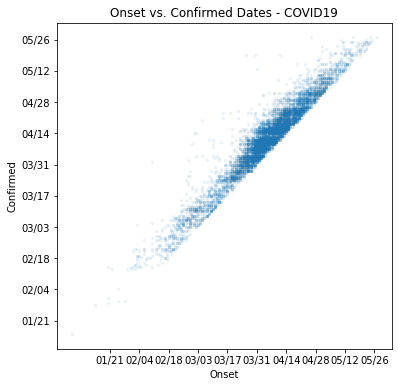

In [11]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

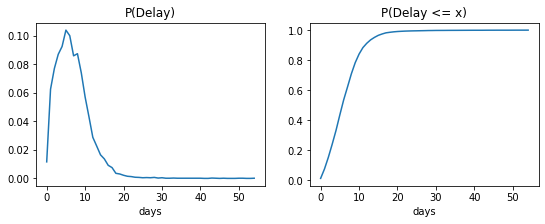

In [12]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')


In [13]:
#import openpyxl
#p_delay.to_excel('/Users/jetto2013/py/p_delay.xlsx')
print(states.xs('Tokyo'))

           POSITIVE
DATE               
2020-01-01        0
2020-01-02        0
2020-01-03        0
2020-01-04        0
2020-01-05        0
...             ...
2020-05-24     5116
2020-05-25     5124
2020-05-26     5134
2020-05-27     5145
2020-05-28     5160

[149 rows x 1 columns]


## A Single State

#### Select State Data

In [14]:
state = 'Tokyo'
confirmed = states.xs(state).POSITIVE.diff().dropna()
confirmed.tail()

DATE
2020-05-24    14
2020-05-25     8
2020-05-26    10
2020-05-27    11
2020-05-28    15
Name: POSITIVE, dtype: object

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [15]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [16]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)

    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

#import openpyxl
#temp = pd.concat([confirmed,onset,adjusted],axis=1)
#temp.to_excel('/Users/jetto2013/py/TOKYO_plus_Adjusted_DATA.xlsx')

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

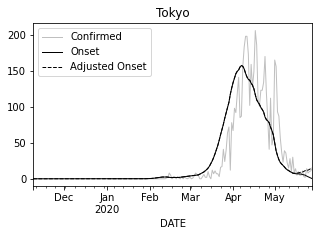

In [17]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [18]:
states = PREPARE()

def CHOICE(STATELIST,original=states):

    if STATELIST == 'Syutoken':
        states = SYUTOKEN(original)
    else:
        states = original.loc[pd.IndexSlice[STATELIST,:],:]
        states = states.sum(level='DATE')
        states['STATE'] = STATELIST 
        states = states.set_index('STATE',append=True)
        states = states.swaplevel(0,1)
    
    return states

def SYUTOKEN(states):
    
    Tokyo = states.loc[pd.IndexSlice['Tokyo',:],:]
    Kanagawa = states.loc[pd.IndexSlice['Kanagawa',:],:]
    Saitama = states.loc[pd.IndexSlice['Saitama',:],:]
    Chiba = states.loc[pd.IndexSlice['Chiba',:],:]

    states = pd.concat([Tokyo,Kanagawa,Saitama,Chiba]).sum(level='DATE')
    states['STATE'] = 'Syutoken'
    states = states.set_index('STATE',append=True)
    states = states.swaplevel(0,1)
    
    return states

#states = CHOICE('Tokyo')

#print(states)

In [19]:
d1 = datetime.strptime('2020-05-28', '%Y-%m-%d')
d0 = datetime.strptime('2020-02-01', '%Y-%m-%d')
window_size = (d1 - d0).days

class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=window_size):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=2, tune=5000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Let the serial interval be a random variable
            # Ref: Hiroshi Nishiuraa, Natalie M. Lintona, Andrei R. Akhmetzhanov
            ###### 'Serial interval of novel coronavirus (COVID-19) infections'
            ######  International Journal of Infectious Diseases 93 (2020) 284–286
            
            ######  serial_interval = pm.Lognormal('serial_interval', mu=4.7, sigma=2.9)
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', mu=0.1, sigma=0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            #calculate r_t            
            r_t = pm.Deterministic('r_t', theta/gamma + 1)
   
            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self


In [20]:
print(window_size)

117


In [21]:
#theta.tag.test_value

### Run Pymc3 Model

In [22]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.POSITIVE.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, adjusted, cumulative_p_delay).run()


In [23]:
models = {}

def COREPROCESS(STATELIST):

    if STATELIST == ['All']:
        STATELIST = all_name
    
    for s in STATELIST:
        states = CHOICE(s)
        print(states)
        for state, grp in states.groupby('STATE'):    
            if state in models:
                print(f'Skipping {state}, already in cache')
                continue
    
            models[state] = create_and_run_model(state,grp.droplevel(0))

    return models

models = COREPROCESS(['Fukuoka'])

                    POSITIVE
STATE   DATE                
Fukuoka 2020-01-01         0
        2020-01-02         0
        2020-01-03         0
        2020-01-04         0
        2020-01-05         0
...                      ...
        2020-05-24       664
        2020-05-25       669
        2020-05-26       671
        2020-05-27       679
        2020-05-28       700

[149 rows x 1 columns]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_raw_steps, theta_raw_init, step_size, serial_interval]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [03:06<00:00, 64.46draws/s] 


### Handle Divergences

In [24]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


Series([], dtype: int64)

## Compile Results

In [25]:
results = None

for state, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

### Render to CSV
Uncomment if you'd like

In [26]:
results.to_csv('/Users/---/rt_fukuoka.csv')

### Render Charts

In [27]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0, 2.5)
    ax.set_title(name)
    ax.plot(result['mean'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['upper_50'].values,
        color='mistyrose',
        lw=0)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['lower_90'].values,
        color='seashell',
        lw=0)
    ax.fill_between(
        result.index,
        result['upper_50'].values,
        result['upper_90'].values,
        color='seashell',
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

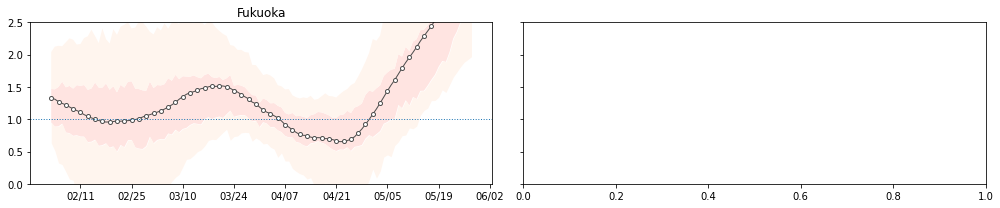

In [28]:
ncols = 2
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('region')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')

In [29]:
# url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
# abbrev = pd.read_csv(url, index_col=['State'], squeeze=True)

# jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
# jhu = pd.read_csv(jhu_url)

# jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
# jhu = jhu.set_index('Province_State')
# jhu.index = jhu.index.rename('region')
# jhu = jhu.drop([
#     'American Samoa',
#     'Guam',
#     'Northern Mariana Islands',
#     'Puerto Rico',
#     'Virgin Islands',
#     'Diamond Princess',
#     'Grand Princess'])

# jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
# jhu.columns = pd.to_datetime(jhu.columns)
# jhu = jhu.groupby('region').sum()
# jhu = jhu.stack().sort_index()

# state = 'VT'
# ax = jhu.xs(state).diff().plot(label='JHU', color='k', legend=True, title=state)
# # jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
# states.xs(state).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
# ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [30]:
# url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-states/regional-summary/rt.csv'

# epf = pd.read_csv(url, parse_dates=['date'])
# epf.region = epf.region.replace(abbrev)
# epf = epf.set_index(['region', 'date']).sort_index()
# epf = epf.drop(['Guam', 'Puerto Rico'])

# epf_lookup = {}
# for idx, grp in epf.groupby('region'):

#     epf_lookup[idx]=grp
#     epf_grp = epf_lookup[state]
    
#     plot_rt(state, result.droplevel(0), ax)
#     plot_rt(state, epf_grp.droplevel(0), ax, c=(1,0,0,1))